In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import random

# Function to preprocess text data
def preprocess_text(text):
    # Implement text cleaning here (e.g., removing URLs, non-alphanumeric characters, etc.)
    return text

# Load dataset
df = pd.read_csv('.../Preprocessed_Combined_Dataset_Relevance.csv')

# Preprocess data
df['processed_tweets'] = df['tweet_text'].apply(preprocess_text)


# Ensure all processed tweets are strings
df['processed_tweets'] = df['processed_tweets'].astype(str)

df

,tweet_id,tweet_text,disaster_type,Event type,Sub-event type,Relevance,text,tidy_tweet,tidy_tweet_tokens,tokens_no_stop,no_stop_joined,processed_tweets
0,'591908028993114113',Treat with extreme caution but this is the USG...,Earthquake,casualty,advice,Relevant,Treat with extreme caution but this is the USG...,treat with extreme caution but this is the usg...,treat with extreme caution but this is the usg...,"['treat', 'extreme', 'caution', 'usgs', 'auto'...",treat extreme caution usgs auto estimate nepal...,Treat with extreme caution but this is the USG...
1,'592088612369465344',Google Innovations Lab executive Dan Fredinbur...,Earthquake,casualty,announcement,Relevant,Google Innovations Lab executive Dan Fredinbur...,google innovations lab executive dan fredinbur...,google innovations lab executive dan fredinbur...,"['google', 'innovations', 'lab', 'executive', ...",google innovations lab executive dan fredinbur...,Google Innovations Lab executive Dan Fredinbur...
2,'592087363439894530',"4/48 children. At Clifton Beach in Karachi, pe...",Earthquake,casualty,destruction,Relevant,"4/48 children. At Clifton Beach in Karachi, pe...",4 48 children at clifton beach in karachi pe...,children at clifton beach in karachi people we...,"['children', 'clifton', 'beach', 'karachi', 'p...",children clifton beach karachi people swimming...,"4/48 children. At Clifton Beach in Karachi, pe..."
3,'592125393542381568',"Nepal earthquake: Hundreds die, many feared tr...",Earthquake,casualty,destruction,Relevant,"Nepal earthquake: Hundreds die, many feared tr...",nepal earthquake hundreds die many feared tr...,nepal earthquake hundreds die many feared trap...,"['nepal', 'hundreds', 'die', 'many', 'feared',...",nepal hundreds die many feared trapped bbc news,"Nepal earthquake: Hundreds die, many feared tr..."
4,'591913071217549312',Avalanche sweeps Everest in Nepal; 30 injured ...,Earthquake,casualty,destruction,Relevant,Avalanche sweeps Everest in Nepal; 30 injured ...,avalanche sweeps everest in nepal 30 injured,avalanche sweeps everest in nepal injured,"['avalanche', 'sweeps', 'everest', 'nepal', 'i...",avalanche sweeps everest nepal injured,Avalanche sweeps Everest in Nepal; 30 injured ...
...,...,...,...,...,...,...,...,...,...,...,...,...
18906,227175995,Prayers!! RT @jacquereid: RT @ABC: New York's ...,Hurricane,spiritual,rescue support,Relevant,Prayers!! RT @jacquereid: RT @ABC: New York's ...,prayers rt jacquereid rt abc new york s ...,prayers rt jacquereid rt abc new york bellevue...,"['prayers', 'rt', 'jacquereid', 'rt', 'abc', '...",prayers rt jacquereid rt abc new york bellevue...,Prayers!! RT @jacquereid: RT @ABC: New York's ...
18907,227175996,All federal government offices in and around W...,Hurricane,information dissemination,closure,Relevant,All federal government offices in and around W...,all federal government offices in and around w...,all federal government offices in and around w...,"['federal', 'government', 'offices', 'around',...",federal government offices around washington c...,All federal government offices in and around W...
18908,227175997,RT @NYTMetro: Limited commuter rail service to...,Hurricane,damage,update,Relevant,RT @NYTMetro: Limited commuter rail service to...,rt nytmetro limited commuter rail service to...,rt nytmetro limited commuter rail service to r...,"['rt', 'nytmetro', 'limited', 'commuter', 'rai...",rt nytmetro limited commuter rail service resu...,RT @NYTMetro: Limited commuter rail service to...
18909,227175998,RT @NYMag: Mayor Bloomberg: The most severe pa...,Hurricane,information dissemination,intensity,Relevant,RT @NYMag: Mayor Bloomberg: The most severe pa...,rt nymag mayor bloomberg the most severe pa...,rt nymag mayor bloomberg the most severe part ...,"['rt', 'nymag', 'mayor', 'bloomberg', 'severe'...",rt nymag mayor bloomberg severe part beginning...,RT @NYMag: Mayor Bloomberg: The most severe pa...


In [ ]:

# Tokenization and Embedding with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(sentence):
    try:
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach().numpy()
    except Exception as e:
        print(f"Error in processing sentence: {sentence}")
        print(f"Error: {e}")
        return np.zeros((1, model.config.hidden_size))  # Return zero array for error sentences

# Apply embeddings to tweets
df['embeddings'] = df['processed_tweets'].apply(get_bert_embeddings)

# Convert list of numpy arrays into a single numpy array
embeddings = np.vstack(df['embeddings'])

# Dimensionality Reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(embeddings)



/home/aaadfg/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


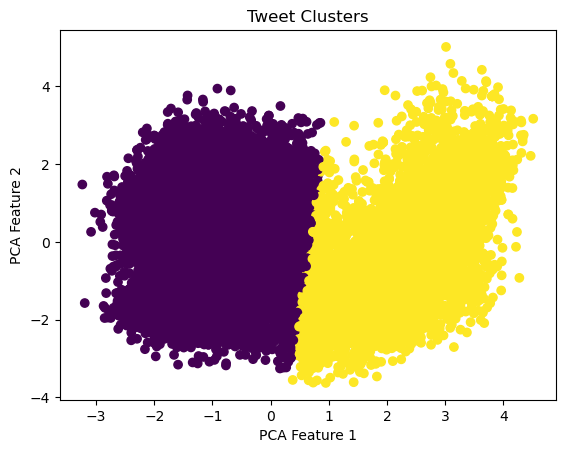

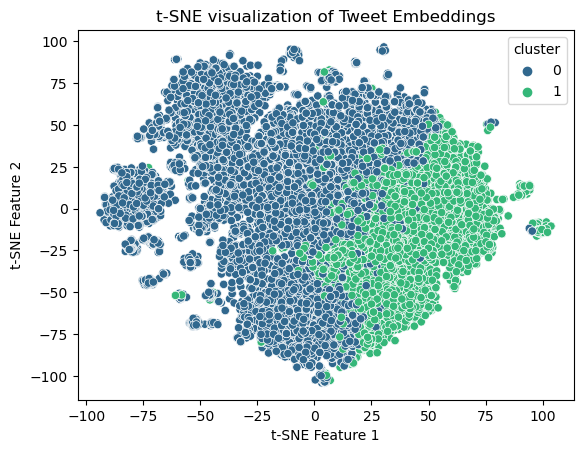

In [ ]:
# Clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_reduced)
df['cluster'] = clusters

# Visualize the clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Tweet Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

# t-SNE transformation and plotting
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster'], palette='viridis')
plt.title('t-SNE visualization of Tweet Embeddings')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()



In [ ]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(X_reduced, clusters)
print(f"Silhouette Score for K-Means clustering: {silhouette_avg}")


Silhouette Score for K-Means clustering: 0.4756428897380829


In [ ]:
# Assuming severity_label column exists in DataFrame
def classify_urgency(label):
    urgent_labels = ['casualty', 'damage', 'die', 'health', 'humanitarian assistance', 'communication', 'resources', 'warning', 'safety']
    return 'Urgent' if label in urgent_labels else 'Not Urgent'

# Apply the function to classify urgency
df['urgency'] = df['Event type'].apply(classify_urgency)

# Save the final DataFrame with cluster, severity, and urgency labels
final_output_file = '.../urgency/final_clustered_tweets.csv'
df.to_csv(final_output_file, index=False)
print(f"Final clustered data with severity and urgency labels saved to {final_output_file}")

Final clustered data with severity and urgency labels saved to /home/aaadfg/Downloads/my_code/urgency/final_clustered_tweets.csv


In [ ]:
# Find nearest neighbors for qualitative analysis
def find_nearest_neighbors(index, embeddings, num_neighbors=5):
    similarities = cosine_similarity([embeddings[index]], embeddings)[0]
    nearest_neighbors = similarities.argsort()[-num_neighbors-1:-1][::-1]
    return nearest_neighbors

# Randomly select a tweet and find its nearest neighbors
random_index = random.randint(0, len(df) - 1)
print("Selected Tweet:", df.iloc[random_index]['text'])
print("\nNearest Neighbors:")
nearest_neighbors_indices = find_nearest_neighbors(random_index, embeddings)
for neighbor_index in nearest_neighbors_indices:
    print(df.iloc[neighbor_index]['text'])

Selected Tweet: @TeklaPerry: Social media giants activate systems designed to let people know if loved ones are safe #NepalEarthquake http://t.co/MBBmVJMkuj

Nearest Neighbors:
@ievaluate My company launched the #NepalRecoveryFund to get money to vetted community-based orgs:http://t.co/1cG4pjrs4L #NepalEarthquake
I hope that someday soon @ReactionHousing will be helping people stricken by disasters. #NepalEarthquake http://t.co/QjnVZrXajE
An amazing blog by @RichendaG + @kylevermeulen: The challenges facing #NFP orgs responding to the #NepalEarthquake http://t.co/DGio9nSppp
Pls. RT: Great primer from @USAID on how to help and stay informed on #NepalQuake: http://t.co/BBzkcyO5oU
RT @OxfamAmerica: Help rush life-saving aid to #NepalEarthquake survivors http://t.co/JPAG0mjZzX
